# **Load ChEMBL data**

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('raw_CHEMBL614725_MIA-PaCa-2.csv',sep=";")
print(df.shape)
df.head(3)

(2182, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL4470501,NaN,0,545.08,0,2.85,5,C[N+](C)(C)CCc1cc(I)c(O)c(I)c1.O=C([O-])C(F)(F)F,IC50,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4321671,Cytotoxicity in human MIAPaCa2 cells incubated...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,MIA PaCa-2,None,NaN,NaN,NaN,CHEMBL614725,MIA PaCa-2,Homo sapiens,CELL-LINE,CHEMBL4316651,1,Scientific Literature,J Nat Prod,2019.0,CHEMBL3308500,NaN
1,CHEMBL4060096,NaN,0,266.34,0,4.34,16b,CCCc1ccc(C2CC=CC(=O)O2)c2ccccc12,IC50,'=',1500.0,nM,5.82,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4057053,Antiproliferative activity against human MIAPa...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,MIA PaCa-2,None,NaN,NaN,NaN,CHEMBL614725,MIA PaCa-2,Homo sapiens,CELL-LINE,CHEMBL4052751,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3308500,NaN
2,CHEMBL1092797,DIHYDROCELASTROL,0,452.64,1,6.64,2,Cc1c(O)c(O)cc2c1CC=C1[C@@]3(C)CC[C@@]4(C)CC[C@...,IC50,'=',720.0,nM,6.14,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4133423,Antiproliferative activity against human MIAPa...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,MIA PaCa-2,None,NaN,NaN,NaN,CHEMBL614725,MIA PaCa-2,Homo sapiens,CELL-LINE,CHEMBL4130422,1,Scientific Literature,Eur J Med Chem,2017.0,CHEMBL3308500,NaN


In [4]:
#print(df.columns)

## **Filter data by standard units**

In [5]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df['Target Organism']))
# Filter data by target_organism=='Homo sapiens'
df=df[df['Target Organism'].isin(['Homo sapiens'])]
print(pd.unique(df['Target Organism']))
print(df.shape)

# Check if the data only has standard_type=='IC50'
print(pd.unique(df['Standard Type']))

print(pd.unique(df['Standard Units']))
# Filter data by units = ['nM','ug.mL-1','uM','pM','ug/g']
units = ['nM','ug.mL-1','uM','pM','ug/g']
df=df[df['Standard Units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df['Standard Units']))
print(df.shape)

['Homo sapiens']
['Homo sapiens']
(2182, 45)
['IC50']
[nan 'nM' 'ug.mL-1' 'ug/g']
['nM' 'ug.mL-1' 'ug/g']
(2115, 45)


# **Data Cleaning**


* Drop missing SMILE notation
* Drop missing standard values
* Drop duplicated assays (by assay ID)


In [6]:
# Drop compounds having missing standard_value.
df2 = df[df['Standard Value'].notna()]
print(df2.shape)

# Drop compounds having missing canonical_smiles column.
df2 = df2[df['Smiles'].notna()]
print(df2.shape)

# Reset index
df2 = df2.reset_index().drop(columns='index')
print(df2.shape)
df2.head(3)

(2115, 45)
(2114, 45)
(2114, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL4060096,NaN,0,266.34,0,4.34,16b,CCCc1ccc(C2CC=CC(=O)O2)c2ccccc12,IC50,'=',1500.0,nM,5.82,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4057053,Antiproliferative activity against human MIAPa...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,MIA PaCa-2,None,NaN,NaN,NaN,CHEMBL614725,MIA PaCa-2,Homo sapiens,CELL-LINE,CHEMBL4052751,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3308500,NaN
1,CHEMBL1092797,DIHYDROCELASTROL,0,452.64,1,6.64,2,Cc1c(O)c(O)cc2c1CC=C1[C@@]3(C)CC[C@@]4(C)CC[C@...,IC50,'=',720.0,nM,6.14,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4133423,Antiproliferative activity against human MIAPa...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,MIA PaCa-2,None,NaN,NaN,NaN,CHEMBL614725,MIA PaCa-2,Homo sapiens,CELL-LINE,CHEMBL4130422,1,Scientific Literature,Eur J Med Chem,2017.0,CHEMBL3308500,NaN
2,CHEMBL2376666,NaN,0,560.32,1,3.82,28,NC(=O)c1c(Nc2ccc(I)cc2F)cc(F)cc1Oc1cccc(NS(N)(...,IC50,'=',23.0,nM,7.64,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL2379930,Antiproliferative activity against human MIAPa...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,MIA PaCa-2,None,NaN,NaN,NaN,CHEMBL614725,MIA PaCa-2,Homo sapiens,CELL-LINE,CHEMBL2375237,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2013.0,CHEMBL3308500,NaN


## **Convert Standard Units**

In [7]:
#df['Molecular Weight']

In [8]:
df2 = df2.sort_values('Standard Value').reset_index().drop(columns='index')
df2[['Standard Units','Standard Value','Molecular Weight']].tail(5)

,Standard Units,Standard Value,Molecular Weight
2109,nM,6.459000e+06,295.73
2110,nM,9.186066e+06,338.21
2111,nM,1.890000e+07,111.03
2112,nM,2.226319e+07,129.17
2113,nM,1.000000e+08,357.79


In [9]:
#units = ['nM','ug.mL-1','uM','pM','ug/g']

standard_unit_nM = []

for i,j,k in zip(df2['Standard Units'],df2['Standard Value'],df2['Molecular Weight']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'ug.mL-1':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))
    elif i == 'ug/g':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))



In [10]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')
print(standard_value_nM.shape)
standard_value_nM.tail(3)

(2114,)


2111    1.890000e+07
2112    2.226319e+07
2113    1.000000e+08
Name: standard_value_nM, dtype: float64

In [11]:
df3 = pd.concat([df2, standard_value_nM], axis=1)
#df3.columns
#df3[['Standard Value','Standard Units','standard_unit_nM']]

print(standard_value_nM.shape)
print(df2.shape)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
df3[['Standard Value','Standard Units','standard_value_nM', 'Molecular Weight']].loc[(df3['Standard Units']=='ug.mL-1')].tail(3)

(2114,)
(2114, 45)
(2114, 46)


,Standard Value,Standard Units,standard_value_nM,Molecular Weight
2039,100.0,ug.mL-1,259457.215505,385.42
2043,100.0,ug.mL-1,269978.401728,370.40
2057,100.0,ug.mL-1,376917.568128,265.31


## **Duplicated Compounds**

In [12]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['Molecule ChEMBL ID','Target ChEMBL ID'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3['standard_value_nM'].head

(1926, 46)


<bound method NDFrame.head of 0       1.300000e-03
1       2.100000e-03
2       1.000000e-01
3       1.100000e-01
4       2.500000e-01
            ...     
1921    6.459000e+06
1922    9.186066e+06
1923    1.890000e+07
1924    2.226319e+07
1925    1.000000e+08
Name: standard_value_nM, Length: 1926, dtype: float64>

In [13]:
# Data pre-processing
# Combine columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame
selection = ['Molecule ChEMBL ID','Smiles','standard_value_nM']
df4 = df3[selection].rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df4.shape)
df4.tail(3)

(1926, 3)


,molecule_chembl_id,canonical_smiles,standard_value_nM
1923,CHEMBL1256289,NC(=O)C(=O)[O-].[Na+],1.890000e+07
1924,CHEMBL1431,CN(C)C(=N)NC(=N)N,2.226319e+07
1925,CHEMBL6,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,1.000000e+08


In [14]:
# Saves to CSV 
df4.to_csv('CHEMBL614725_bioactivity_data_preprocessed.csv', index=False)

# **Labeling** 

In [15]:
import pandas as pd

df5 = pd.read_csv('CHEMBL614725_bioactivity_data_preprocessed.csv')
df5.tail(3)

,molecule_chembl_id,canonical_smiles,standard_value_nM
1923,CHEMBL1256289,NC(=O)C(=O)[O-].[Na+],1.890000e+07
1924,CHEMBL1431,CN(C)C(=N)NC(=N)N,2.226319e+07
1925,CHEMBL6,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,1.000000e+08


### Distribution


In [16]:
import seaborn as sns
import numpy as np
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [17]:
#df5.standard_value_nM.describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


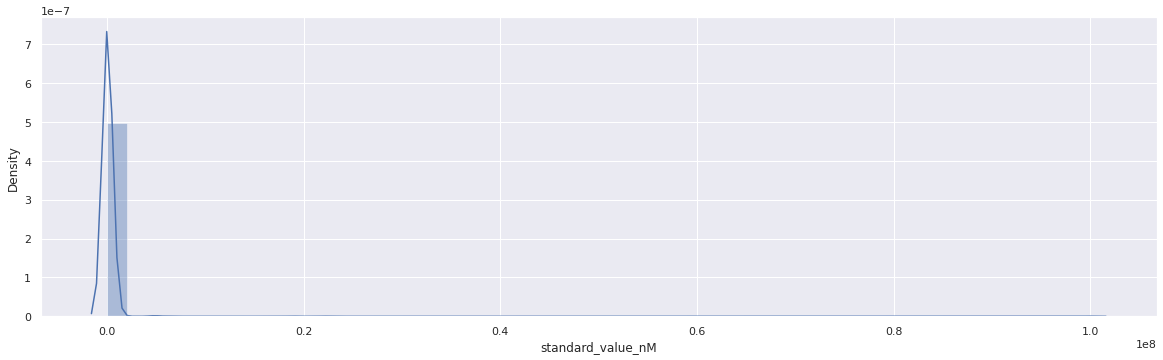

In [18]:
plt.figure(figsize=(20,5.5))
sns.set_theme(); 
ax = sns.distplot(df5['standard_value_nM'])

### Scaling (pIC50)


To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [19]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [20]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [22]:
# Normalization
df6 = norm_value(df5)
df_norm = pIC50(df6)
df_norm.head #.pIC50.describe()

<bound method NDFrame.head of      molecule_chembl_id  ...      pIC50
0         CHEMBL2321905  ...  11.886057
1         CHEMBL2324630  ...  11.677781
2         CHEMBL4176275  ...  10.000000
3         CHEMBL2324627  ...   9.958607
4         CHEMBL2324629  ...   9.602060
...                 ...  ...        ...
1921       CHEMBL549659  ...   2.189835
1922       CHEMBL483849  ...   2.036870
1923      CHEMBL1256289  ...   1.723538
1924         CHEMBL1431  ...   1.652413
1925            CHEMBL6  ...   1.000000

[1926 rows x 3 columns]>

In [23]:
#df_norm.pIC50.describe()

#### **Distribution plots**

In [25]:
botton_line = np.percentile(df_norm.pIC50, 20)
top_line = np.percentile(df_norm.pIC50, 80)
print(botton_line,top_line)

4.031517051446065 5.823908740944319


In [26]:
'''plt.figure(figsize=(16, 4))

sns.set_theme(); 

ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')
kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#EF9A9A')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , 
                interpolate=True, color='#EF9A9A')'''

"plt.figure(figsize=(16, 4))\n\nsns.set_theme(); \n\nax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')\nkde_x, kde_y = ax.lines[0].get_data()\n\n#plotting the two lines\np1 = plt.axvline(x=botton_line,color='#EF9A9A')\np2 = plt.axvline(x=top_line,color='#EF9A9A')\n\nax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , \n                interpolate=True, color='#EF9A9A')"

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


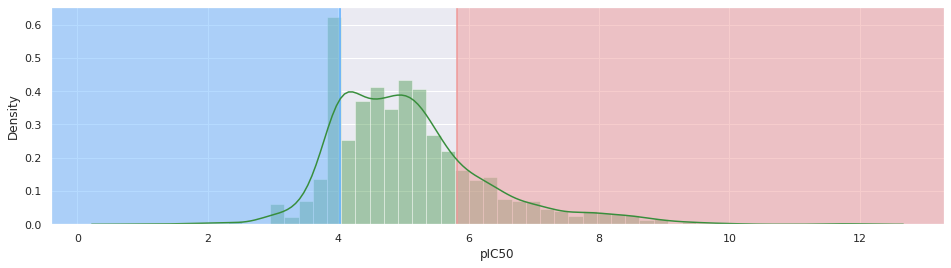

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

## **Labeling**

In [28]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append("active")
  elif float(i) <= botton_line:
    bioactivity_threshold.append("inactive")
  else:
    bioactivity_threshold.append("intermediate")

In [29]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df7 = pd.concat([df_norm, bioactivity_class], axis=1)
print(df7.shape)
df7.head(3)

(1926, 4)


,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL2321905,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...,11.886057,active
1,CHEMBL2324630,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...,11.677781,active
2,CHEMBL4176275,COc1c(Br)c2c(c(OC)c1OC)-c1cc3cc(CO)n(C)c3cc1[C...,10.000000,active


In [30]:
print(
    ' active',df7['bioactivity_class'][df7['bioactivity_class']=="active"].count(),'\n',
    'inactive',df7['bioactivity_class'][df7['bioactivity_class']=="inactive"].count(),'\n',
    'intermediate',df7['bioactivity_class'][df7['bioactivity_class']=="intermediate"].count()
)

 active 386 
 inactive 386 
 intermediate 1154


Saves dataframe to CSV file

In [31]:
df7.to_csv('CHEMBL614725_bioactivity_data_curated.csv', index=False)

# **Removing 'intermediate' class**

In [35]:
df_2class = df7[df7['bioactivity_class'] != 'intermediate']
df_2class.shape

(772, 4)

In [36]:
df_2class.to_csv('CHEMBL614725_2classes_data.csv', index=False)

# **Exporatory Data Analysis**

## **Install conda and rdkit**

In [37]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-08 18:58:59--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   135MB/s    in 0.6s    

2021-04-08 18:59:00 (135 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

## **Lipinski 5-rule descriptors**


In [38]:
import pandas as pd

In [39]:
df = pd.read_csv('CHEMBL614725_2classes_data.csv')
df.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL2321905,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...,11.886057,active
1,CHEMBL2324630,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...,11.677781,active
2,CHEMBL4176275,COc1c(Br)c2c(c(OC)c1OC)-c1cc3cc(CO)n(C)c3cc1[C...,10.000000,active


### **Import libraries**

In [40]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [41]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [42]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski.head(3)

,MW,LogP,NumHDonors,NumHAcceptors
0,666.735,5.19630,2.0,10.0
1,667.723,4.59130,2.0,11.0
2,503.393,4.24930,2.0,6.0
3,681.750,4.98140,2.0,11.0
4,789.850,5.18210,3.0,13.0
...,...,...,...,...
767,295.729,4.53830,1.0,3.0
768,338.213,-2.70730,6.0,9.0
769,111.032,-5.77440,1.0,3.0
770,129.167,-1.03416,4.0,2.0


In [43]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL2321905,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...,11.886057,active,666.735,5.1963,2.0,10.0
1,CHEMBL2324630,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...,11.677781,active,667.723,4.5913,2.0,11.0
2,CHEMBL4176275,COc1c(Br)c2c(c(OC)c1OC)-c1cc3cc(CO)n(C)c3cc1[C...,10.000000,active,503.393,4.2493,2.0,6.0


In [44]:
df_combined.to_csv('CHEMBL614725_2classes_lipinski_EDA_data.csv', index=False)

## **Chemical Space Analysis**

### **Import library**

In [45]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Statistical analysis | Mann-Whitney U Test**

In [46]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'CHEMBL614725_MIA-PaCa-2_mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

### **Scatter plot of MW versus LogP**



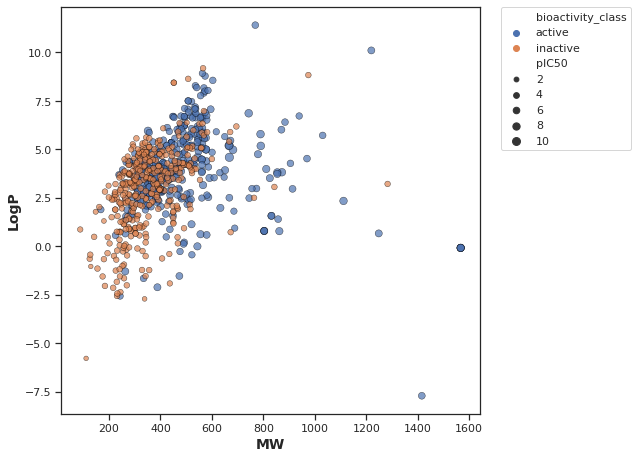

In [47]:
plt.figure(figsize=(7.5, 7.5))

sns.scatterplot(x='MW', y='LogP', data=df_combined, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('CHEMBL614725_MIA-PaCa-2_plot_MW_vs_LogP.pdf')

### **Box plots &　Hypothesis Test**

#### **MW**

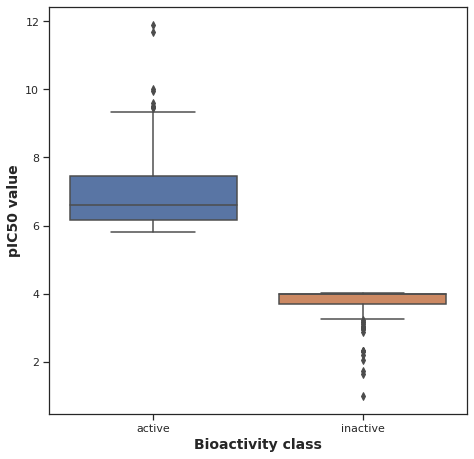

In [48]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL614725_MIA-PaCa-2_plot_ic50.pdf')

In [49]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,35625.0,2.051980e-36,0.05,Different distribution (reject H0)


#### **LogP**

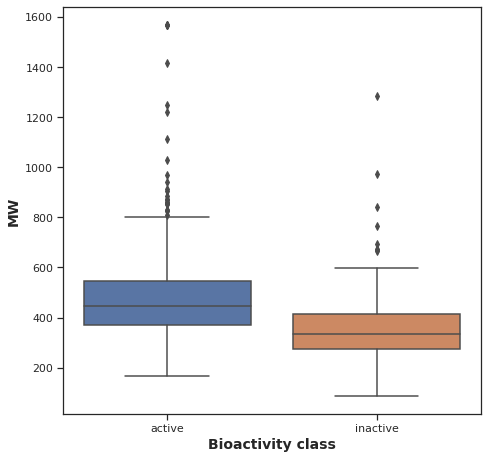

In [50]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL614725_MIA-PaCa-2_plot_MW.pdf')

#### **NumHDonors**

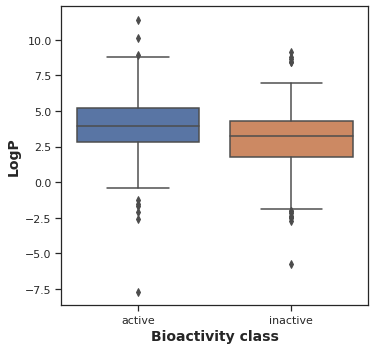

In [51]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL614725_MIA-PaCa-2_plot_LogP.pdf')

In [52]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,64503.5,0.000445,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

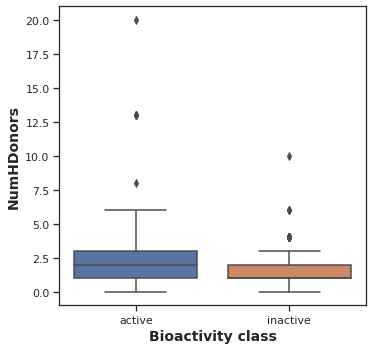

In [53]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL614725_MIA-PaCa-2_plot_NumHDonors.pdf')

In [54]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,53854.0,9.183939e-12,0.05,Different distribution (reject H0)


# **Zip files**

In [55]:
! zip -r results.zip . -i *.csv *.pdf

  adding: CHEMBL614725_2classes_lipinski_EDA_data.csv (deflated 74%)
  adding: CHEMBL614725_MIA-PaCa-2_mannwhitneyu_MW.csv (deflated 9%)
  adding: CHEMBL614725_MIA-PaCa-2_mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: CHEMBL614725_bioactivity_data_curated.csv (deflated 78%)
  adding: CHEMBL614725_MIA-PaCa-2_plot_ic50.pdf (deflated 37%)
  adding: CHEMBL614725_MIA-PaCa-2_plot_MW.pdf (deflated 38%)
  adding: CHEMBL614725_2classes_data.csv (deflated 77%)
  adding: CHEMBL614725_MIA-PaCa-2_plot_NumHDonors.pdf (deflated 39%)
  adding: CHEMBL614725_MIA-PaCa-2_plot_LogP.pdf (deflated 40%)
  adding: CHEMBL614725_MIA-PaCa-2_plot_MW_vs_LogP.pdf (deflated 5%)
  adding: CHEMBL614725_bioactivity_data_preprocessed.csv (deflated 77%)
  adding: CHEMBL614725_MIA-PaCa-2_mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: raw_CHEMBL614725_MIA-PaCa-2.csv (deflated 88%)


# **Calculate fingerprint descriptors**

## **Download PaDEL-Descriptor**

In [56]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-08 19:00:52--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  5.09MB/s    in 3.9s    

2021-04-08 19:00:56 (5.09 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [57]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [58]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Load bioactivity data**

In [59]:
import pandas as pd

In [60]:
df = pd.read_csv('CHEMBL614725_2classes_lipinski_EDA_data.csv')
df.tail(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
769,CHEMBL1256289,NC(=O)C(=O)[O-].[Na+],1.723538,inactive,111.032,-5.77440,1.0,3.0
770,CHEMBL1431,CN(C)C(=N)NC(=N)N,1.652413,inactive,129.167,-1.03416,4.0,2.0
771,CHEMBL6,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1,1.000000,inactive,357.793,3.92732,1.0,4.0


In [61]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [62]:
! cat molecule.smi | head -5

COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c(cc4OC)C(=O)N4CCC[C@H]4C=N5)cn3C)cc2)cn1C	CHEMBL2321905
COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c(cc4OC)C(=O)N4CCC[C@H]4C=N5)cn3C)cc2)cn1C	CHEMBL2324630
COc1c(Br)c2c(c(OC)c1OC)-c1cc3cc(CO)n(C)c3cc1[C@@H](NC(C)=O)CC2	CHEMBL4176275
CCOC(=O)c1nc(NC(=O)c2cc(-c3ccc(NC(=O)CCCOc4cc5c(cc4OC)C(=O)N4CCC[C@H]4C=N5)cc3)cn2C)cn1C	CHEMBL2324627
COC(=O)c1nc(NC(=O)c2cc(NC(=O)c3cc(-c4ccc(NC(=O)CCCOc5cc6c(cc5OC)C(=O)N5CCC[C@H]5C=N6)cc4)cn3C)cn2C)cn1C	CHEMBL2324629


In [63]:
! cat molecule.smi | wc -l

772


## **Calculate PaDEL descriptors**

In [64]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL2321905 in molecule.smi (1/772). 
Processing CHEMBL2324630 in molecule.smi (2/772). 
Processing CHEMBL4176275 in molecule.smi (3/772). 
Processing CHEMBL2324627 in molecule.smi (4/772). Average speed: 2.62 s/mol.
Processing CHEMBL2324628 in molecule.smi (6/772). Average speed: 2.47 s/mol.
Processing CHEMBL2324629 in molecule.smi (5/772). Average speed: 2.39 s/mol.
Processing CHEMBL2324626 in molecule.smi (7/772). Average speed: 1.85 s/mol.
Processing CHEMBL2324625 in molecule.smi (8/772). Average speed: 1.55 s/mol.
Processing CHEMBL4458738 in molecule.smi (9/772). Average speed: 1.48 s/mol.
Processing CHEMBL4439731 in molecule.smi (10/772). Average speed: 1.40 s/mol.
Processing CHEMBL450955 in molecule.smi (11/772). Average speed: 1.25 s/mol.
Processing CHEMBL126916 in molecule.smi (12/772). Average speed: 1.31 s/mol.
Processing CHEMBL385064 in molecule.smi (13/772). Average speed: 1.19 s/mol.
Processing CHEMBL4539214 in molecule.smi (14/772). Average speed: 1.11 s/mol

In [65]:
! ls -l

total 108368
-rw-r--r-- 1 root root  1383525 Apr  8 19:04 binary_descriptors_output.csv
-rw-r--r-- 1 root root    71036 Apr  8 18:58 CHEMBL614725_2classes_data.csv
-rw-r--r-- 1 root root   103777 Apr  8 19:00 CHEMBL614725_2classes_lipinski_EDA_data.csv
-rw-r--r-- 1 root root   187381 Apr  8 18:58 CHEMBL614725_bioactivity_data_curated.csv
-rw-r--r-- 1 root root   151258 Apr  8 18:56 CHEMBL614725_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root      122 Apr  8 19:00 CHEMBL614725_MIA-PaCa-2_mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      131 Apr  8 19:00 CHEMBL614725_MIA-PaCa-2_mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      129 Apr  8 19:00 CHEMBL614725_MIA-PaCa-2_mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root    15319 Apr  8 19:00 CHEMBL614725_MIA-PaCa-2_plot_ic50.pdf
-rw-r--r-- 1 root root    13907 Apr  8 19:00 CHEMBL614725_MIA-PaCa-2_plot_LogP.pdf
-rw-r--r-- 1 root root    13632 Apr  8 19:00 CHEMBL614725_MIA-PaCa-2_plot_MW.pdf
-rw-r--r-- 1 root root   148942 Apr

# **Preparing the X and Y Data Matrices**

## **X data matrix**

In [66]:
df_X = pd.read_csv('binary_descriptors_output.csv')
df_X.head(5)

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL2324630,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL2321905,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL4176275,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL2324627,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL2324629,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
df_X = df_X.drop(columns=['Name'])
print(df_X.shape)
df_X.head(3)

(772, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Y variable**

In [68]:
df_Y = df['bioactivity_class']
df_Y.shape

(772,)

## **Final dataset**

In [69]:
df_final = pd.concat([df_X,df_Y], axis=1)
print(df_final.shape)
df_final.head(3)

(772, 882)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,bioactivity_class
0,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active


In [70]:
df_final.to_csv('CHEMBL614725_MIA-PaCa-2_2class_pubchem_fp.csv', index=False)

In [71]:
import pandas as pd

In [73]:
df = pd.read_csv('CHEMBL614725_MIA-PaCa-2_2class_pubchem_fp.csv')
df.head

<bound method NDFrame.head of      PubchemFP0  PubchemFP1  ...  PubchemFP880  bioactivity_class
0             1           1  ...             0             active
1             1           1  ...             0             active
2             1           1  ...             0             active
3             1           1  ...             0             active
4             1           1  ...             0             active
..          ...         ...  ...           ...                ...
767           1           1  ...             0           inactive
768           0           0  ...             0           inactive
769           1           1  ...             0           inactive
770           1           1  ...             0           inactive
771           1           1  ...             0           inactive

[772 rows x 882 columns]>